Random Forest using Kaggle Animal Shelter Dataset
https://www.kaggle.com/c/shelter-animal-outcomes

# Pre-processing the animal shelter dataset

In [71]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv as csv
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, log_loss, average_precision_score

from textblob import TextBlob

import logging

%matplotlib inline

In [72]:
# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')

In [73]:
# Set up my data directories from different machines

mac_data_dir = '/Users/christopherallison/Documents/Coding/Data'
linux_data_dir = '/home/chris/data'
win_data_dir = u'C:\\Users\\Owner\\Documents\\Data'

In [74]:
# Set data directory for example

data_dir = mac_data_dir

In [75]:
# Load TRAINING DATA

train_df = pd.read_csv(os.path.join(data_dir, 'shelter_train.csv'), header=0)        # Load the train file into a dataframe

In [76]:
# Data exploration - what headers do we have?

train_df.columns

Index(['AnimalID', 'Name', 'DateTime', 'OutcomeType', 'OutcomeSubtype',
       'AnimalType', 'SexuponOutcome', 'AgeuponOutcome', 'Breed', 'Color'],
      dtype='object')

In [77]:
# At first blush, there is an obvious difference between dogs & cats.  To start exploring the data, and for this
# Example, we'll narrow the focus to only dogs.

train_dogs = train_df.where(train_df['AnimalType']=='Dog')

# This creates a DF with NaN where non-Dogs used to be, so we

train_dogs.dropna(inplace=True)

In [78]:
# Let's look at our data

train_dogs.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
5,A677334,Elsa,2014-04-25 13:04:00,Transfer,Partner,Dog,Intact Female,1 month,Cairn Terrier/Chihuahua Shorthair,Black/Tan
12,A684601,Rocket,2016-02-03 11:27:00,Adoption,Foster,Dog,Neutered Male,4 years,Pit Bull Mix,Brown
20,A670658,Anders,2014-01-19 15:03:00,Transfer,Partner,Dog,Intact Male,2 months,Queensland Heeler Mix,Black/White
31,A707341,Murphy,2015-07-15 15:25:00,Transfer,Partner,Dog,Intact Male,4 months,Labrador Retriever Mix,Black/White


In [79]:
# And get a better overall feel for it.

train_dogs.describe()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
count,3950,3950,3950,3950,3950,3950,3950,3950,3950,3950
unique,3950,2138,3571,4,14,1,5,35,626,163
top,A676264,Bella,2015-11-23 00:00:00,Transfer,Partner,Dog,Neutered Male,2 years,Pit Bull Mix,Black/White
freq,1,33,8,2673,2673,3950,1562,740,614,423


Of interest - our original dataset was 27,600 animals - only 3950 are dogs

In [80]:
# Now that we're only looking at dogs, we can drop this as a variable

train_dogs.AnimalType.unique()
train_dogs.drop('AnimalType', 1, inplace=True)

In [81]:
# So let's see what outcomes we're mapping against.

outcomes = train_dogs.OutcomeType.unique()
outcomes

array(['Adoption', 'Transfer', 'Euthanasia', 'Died'], dtype=object)

Of interest - Dogs aren't returned to their owners. Cats are. WTF?

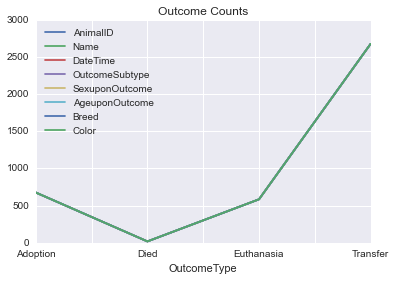

In [82]:
# Let's explore the data a bit more.  How do these outcomes map to our data?

counts = train_dogs.groupby('OutcomeType').count()
counts.plot.line(title="Outcome Counts")

Next we'll look at the outcome subtype. This isn't an element of our test data, so we shouldn't build it directly into our classifier, but we can use it to help us understand our data.

As an aside, this seems like very useful data to have on intake (and it bumps our accuracy up to 80+% when we use it).

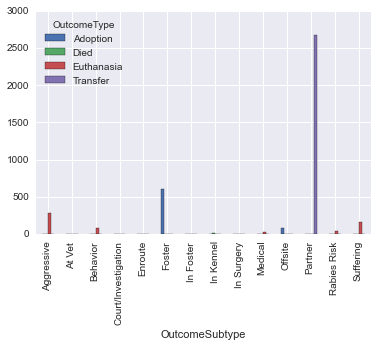

In [83]:
dates_cross = pd.crosstab(train_dogs.OutcomeSubtype, train_dogs.OutcomeType)
dates_cross.plot.bar()

Interesting. The outcome types are fairly siloed depending on the subtype.  Some questions:
* Where do transferred dogs go?  Is shuffling them around an issue?  What are the outcomes after the transfer?
* At what point do the behavior, agression and suffering subtype outcomes come into play?

We need to transform the string categories into integers to work with the machine learning models.

Let's start by doing this for the animal sex feature.

In [84]:
# First, let's check out the different values

train_dogs.SexuponOutcome.unique()

array(['Neutered Male', 'Intact Female', 'Intact Male', 'Spayed Female',
       'Unknown'], dtype=object)

In [85]:
# Then we'll create a dictionary through which we can transform and revert the values to strings.
# We can also use the LabelEncoder() function - but this seems easier.

def transform_string_label_to_integer(dictionary, dataframe_column):
    # takes dictionary and dataframe column and returns translation dict
    for i, label in enumerate(dataframe_column.unique()):
        dictionary[label] = i

In [86]:
sex_outcome = {}

transform_string_label_to_integer(sex_outcome, train_dogs.SexuponOutcome)

In [87]:
sex_outcome

{'Intact Female': 1,
 'Intact Male': 2,
 'Neutered Male': 0,
 'Spayed Female': 3,
 'Unknown': 4}

In [88]:
train_dogs['SexuponOutcome'] = train_df.SexuponOutcome.map( sex_outcome )

In [89]:
train_dogs.AgeuponOutcome.unique()

array(['2 years', '1 month', '4 years', '2 months', '4 months', '3 years',
       '11 years', '6 months', '1 year', '12 years', '7 years', '7 months',
       '5 years', '5 months', '3 months', '6 years', '9 years', '10 years',
       '11 months', '8 months', '10 months', '8 years', '9 months',
       '13 years', '2 weeks', '14 years', '15 years', '16 years',
       '17 years', '1 weeks', '19 years', '3 days', '1 week', '4 weeks',
       '6 days'], dtype=object)

And now we come to age.  This seems to be a text field, but pretty standard, so we'll just set up a quick function to group it into standard age groups (pulled from doggie websites). Possible issue: dogs of different sizes age differently. (Should we convert breed to size and modify the age feature?)

In [90]:
period_dict = {'year': 365, 'month': 30, 'week': 7, 'day': 1, 'day': 1}

age_group = {0: "puppy", 1: "adolescent", 2: "adult", 3: "senior"}

def convert_age_to_group(age):
    # Convert input age into age groupings
    try:
        number, period = str(age).split()
        period = period.rstrip("s")
        days = int(number) * period_dict[period]
        
        if days < 365:
            return 0
        elif days < 730:
            return 1
        elif days < 2190:
            return 2
        else:
            return 3
        
    except ValueError:
        return 3
    

In [91]:
# Test our script

age_group[convert_age_to_group('8 weeks')]

'puppy'

And we transform the AgeuponOutcome column to our groups.

In [92]:
train_dogs['AgeuponOutcome'] = train_dogs.AgeuponOutcome.apply(convert_age_to_group)

In [93]:
train_dogs.AgeuponOutcome.unique()

array([2, 0, 3, 1])

Now that we've grouped our data, let's look at how age effects outcome.

In [94]:
ages_n_outcomes = pd.crosstab(train_dogs.AgeuponOutcome, train_dogs.OutcomeType)

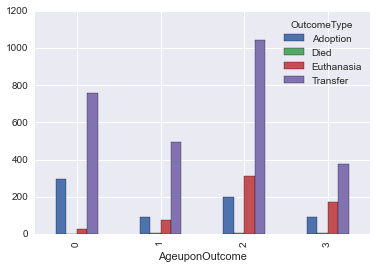

In [96]:
ages_n_outcomes.plot.bar()

Of interest here is the previous graph that showed that euthanized dogs were related to the OutcomeSubtypes for agression, etc.

So, we see that puppies are more likely to be adopted and adults are more likely to be euthanized, but looking at our counts again will help us interpret this data.

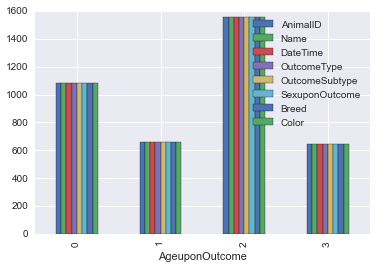

In [97]:
counts = train_dogs.groupby('AgeuponOutcome').count().plot.bar()

We should really do the same thing with color... But we're short on time here.

In [98]:
train_dogs.Color.unique()

array(['Blue/White', 'Black/Tan', 'Brown', 'Black/White', 'Brown/Black',
       'Buff', 'Brown Brindle/White', 'Tan', 'White', 'Brown Brindle',
       'White/Black', 'Yellow Brindle/White', 'White/Brown', 'Tricolor',
       'Brown/White', 'Red', 'Tan/White', 'White/Tan', 'Yellow',
       'Brown Tiger/White', 'Black', 'Blue Merle/White', 'Blue',
       'Buff/Tan', 'Chocolate/White', 'Blue Tiger/White', 'Gray',
       'Blue Tick', 'Black/Brown', 'Sable', 'White/Gray', 'Brown/Tan',
       'Red/White', 'Tan/Black', 'Yellow/White', 'Cream',
       'Blue Cream/Blue Tiger', 'Blue Merle/Gray', 'Chocolate/Tan',
       'Black Brindle/White', 'White/Blue', 'Fawn', 'Brown Merle',
       'White/Red', 'White/Brown Brindle', 'Brown/Brown', 'Fawn/White',
       'Cream/White', 'White/Cream', 'Blue/Tan', 'Brown Brindle/Black',
       'Blue Merle', 'Black/Tricolor', 'Gray/White', 'Red Tick/White',
       'Silver/Brown', 'Black/Brown Brindle', 'Black Brindle',
       'Black/Blue Merle', 'Brown/Tricolor', 

Some people really like their dogs...  That is a lot of colours.

In [99]:
len(train_dogs.Color.unique())

163

We're still exploring here, so we will radically simplify the list.

In [100]:
def simplify_colors(color):
    sc = color.lower().replace("/"," ").split(" ")
    return sc[0]

In [101]:
simplify_colors("Black Brindle/Brown")

'black'

In [102]:
train_dogs.Color = train_dogs.Color.apply(simplify_colors)

In [103]:
len(train_dogs.Color.unique())

19

In [104]:
color = {}

transform_string_label_to_integer(color, train_dogs.Color)
    
train_dogs['Color'] = train_dogs.Color.map( color ).astype(int)

In [105]:
# We could also do something very cool with text analysis for names, but we'll keep it simple and go length

train_dogs['NameLength'] = train_df.Name.apply(lambda x: len(str(x)))

We've done a lot of pre-processing and have a good idea what our dataset looks like.  The Breed feature will be tricky, though, so let's save what we've done.

In [106]:
train_dogs.interpolate(inplace=True) # could have used dropna().median()
train_dogs.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,SexuponOutcome,AgeuponOutcome,Breed,Color,NameLength
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,0,2,Pit Bull Mix,0,6
5,A677334,Elsa,2014-04-25 13:04:00,Transfer,Partner,1,0,Cairn Terrier/Chihuahua Shorthair,1,4
12,A684601,Rocket,2016-02-03 11:27:00,Adoption,Foster,0,2,Pit Bull Mix,2,6
20,A670658,Anders,2014-01-19 15:03:00,Transfer,Partner,2,0,Queensland Heeler Mix,1,6
31,A707341,Murphy,2015-07-15 15:25:00,Transfer,Partner,2,0,Labrador Retriever Mix,1,6


In [107]:
# Save our clean dataframe to csv so we don't need to do this again.
train_dogs.to_csv(os.path.join(data_dir, "dogs_clean_train.csv"))

### K-Means for Breed types

In [108]:
# Let's reload our dataframe.

train_dogs = pd.read_csv(os.path.join(data_dir, "dogs_clean_train.csv"), index_col=0)

In [109]:
train_dogs.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,SexuponOutcome,AgeuponOutcome,Breed,Color,NameLength
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,0,2,Pit Bull Mix,0,6
5,A677334,Elsa,2014-04-25 13:04:00,Transfer,Partner,1,0,Cairn Terrier/Chihuahua Shorthair,1,4
12,A684601,Rocket,2016-02-03 11:27:00,Adoption,Foster,0,2,Pit Bull Mix,2,6
20,A670658,Anders,2014-01-19 15:03:00,Transfer,Partner,2,0,Queensland Heeler Mix,1,6
31,A707341,Murphy,2015-07-15 15:25:00,Transfer,Partner,2,0,Labrador Retriever Mix,1,6


And look at the Breed feature.

In [110]:
train_dogs.Breed.unique()

array(['Pit Bull Mix', 'Cairn Terrier/Chihuahua Shorthair',
       'Queensland Heeler Mix', 'Labrador Retriever Mix',
       'Chihuahua Shorthair Mix', 'Yorkshire Terrier Mix', 'Pointer Mix',
       'English Foxhound', 'Cardigan Welsh Corgi/Chihuahua Shorthair',
       'Chihuahua Shorthair', 'Lhasa Apso', 'German Shepherd Mix',
       'Border Collie Mix', 'Boxer Mix', 'Chihuahua Shorthair/Dachshund',
       'Miniature Pinscher/Chihuahua Shorthair', 'Dachshund Mix',
       'Australian Cattle Dog Mix', 'Catahoula/Labrador Retriever',
       'Whippet Mix', 'Rat Terrier Mix', 'English Pointer Mix',
       'Labrador Retriever/Pit Bull', 'Basset Hound/Labrador Retriever',
       'Airedale Terrier Mix', 'Chihuahua Shorthair/Rat Terrier',
       'Cocker Spaniel', 'Plott Hound Mix', 'Dachshund',
       'Border Collie/Labrador Retriever', 'Great Dane', 'Akita/Pit Bull',
       'Labrador Retriever', 'Rottweiler Mix',
       'Labrador Retriever/Blue Lacy', 'Dachshund/Chihuahua Shorthair',
       '

That is a lot of breeds...

In [111]:
len(train_dogs.Breed.unique())

626

In [112]:
# This seems like it could be important, so let's try grouping them together.  We could do this manually, or...

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
count_vect = CountVectorizer()

### Document tokenization

In [113]:
def split_into_lemmas(message):
    # transform texts into tokens and preprocess
    words = TextBlob(message.replace("/", " ").lower()).words
    # for each word, take its "base form" = lemma 
    return [word.lemma for word in words]

In [114]:
train_dogs.Breed.head().apply(split_into_lemmas)

2                           [pit, bull, mix]
5     [cairn, terrier, chihuahua, shorthair]
12                          [pit, bull, mix]
20                 [queensland, heeler, mix]
31                [labrador, retriever, mix]
Name: Breed, dtype: object

Now we create a bag of words transformer based on the full texts in the Breed feature.

In [115]:
bow_transformer = CountVectorizer(analyzer=split_into_lemmas).fit(train_dogs.Breed)
len(bow_transformer.vocabulary_)

202

That's a bit more manageable.  Let's try out our transformer.

In [116]:
bow_transformer.get_feature_names()[3]

'alaskan'

So let's take a look at what our matrix looks like.  A key element to the BoW model is that it's a sparse matrix. Each value only references the tokens that comprise it. The rest are (silently) assumed to be 0.

In [117]:
breed_bow = bow_transformer.transform(train_dogs.Breed)
print( 'sparse matrix shape:', breed_bow.shape)
print( 'number of non-zeros:', breed_bow.nnz)
print ('sparsity: %.2f%%' % (100.0 * breed_bow.nnz / (breed_bow.shape[0] * breed_bow.shape[1])))

sparse matrix shape: (3950, 202)
number of non-zeros: 11899
sparsity: 1.49%


Now we can take a document and convert it into its counts.

In [118]:
print(breed_bow[1])

  (0, 33)	1
  (0, 43)	1
  (0, 166)	1
  (0, 183)	1


So now we have our Bag of Words. We'll add it into our dataframe.

Next we need to set up a Term-frequency, inverse document frequency transformer. This is a statistical way of determining which words are most important out of a corpus.

You can learn more about feature extraction here: http://scikit-learn.org/stable/modules/feature_extraction.html

In [119]:
# First, we fit the transformer to our BoW

tfidf_transformer = TfidfTransformer().fit(breed_bow)

In [120]:
# Then we transform it.

breed_tfidf = tfidf_transformer.transform(breed_bow)

for e in breed_tfidf[5]:
    print(e)

  (0, 166)	0.677076995403
  (0, 114)	0.321458580066
  (0, 43)	0.661990274549


From here, we can cluster the breed data using several options.

## KMeans Clustering

In [121]:
# Select number of clusters for KMeans clustering
n_clusters = 5

In [122]:
# Import and set up our classifier

from sklearn.cluster import KMeans

km = KMeans(n_clusters=n_clusters, init='k-means++', n_init=1, verbose=1)

In [123]:
# Fit the KM classifier on our TFIDF

km_breeds = km.fit_predict(breed_tfidf)

Initialization complete
Iteration  0, inertia 4721.882
Iteration  1, inertia 2853.990
Iteration  2, inertia 2679.720
Iteration  3, inertia 2662.656
Iteration  4, inertia 2662.640
Converged at iteration 4


KMeans stops when it stops making progress on it's clustering.

Now we have a working machine learning classifier on which we can predict our feature.

In [124]:
km.predict(breed_tfidf[4])

array([0], dtype=int32)

In [125]:
# Visualizing the K-Means clusters via TSNE
# t-distributed Stochastic Neighbor Embedding.

from sklearn.manifold import TSNE

http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

In [126]:
# First we use the TruncatedSVD to perform linear dimensionality reduction (truncated singular value decomposition (SVD)).

from sklearn.decomposition import TruncatedSVD

X_reduced = TruncatedSVD(n_components=50, random_state=0).fit_transform(breed_tfidf)

In [127]:
X_embedded = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(X_reduced)


[t-SNE] Computing pairwise distances...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 3950
[t-SNE] Computed conditional probabilities for sample 2000 / 3950
[t-SNE] Computed conditional probabilities for sample 3000 / 3950
[t-SNE] Computed conditional probabilities for sample 3950 / 3950
[t-SNE] Mean sigma: 0.000000
[t-SNE] Iteration 25: error = 1.2037024, gradient norm = 0.0131497
[t-SNE] Iteration 50: error = 1.0929360, gradient norm = 0.0094686
[t-SNE] Iteration 75: error = 0.6592954, gradient norm = 0.0108548
[t-SNE] Iteration 100: error = 0.5818592, gradient norm = 0.0073063
[t-SNE] Error after 100 iterations with early exaggeration: 0.581859
[t-SNE] Iteration 125: error = 0.4310890, gradient norm = 0.0091767
[t-SNE] Iteration 150: error = 0.3998433, gradient norm = 0.0079487
[t-SNE] Iteration 175: error = 0.3887509, gradient norm = 0.0075832
[t-SNE] Iteration 200: error = 0.3987697, gradient norm = 0.0077983
[t-SNE] Iterat

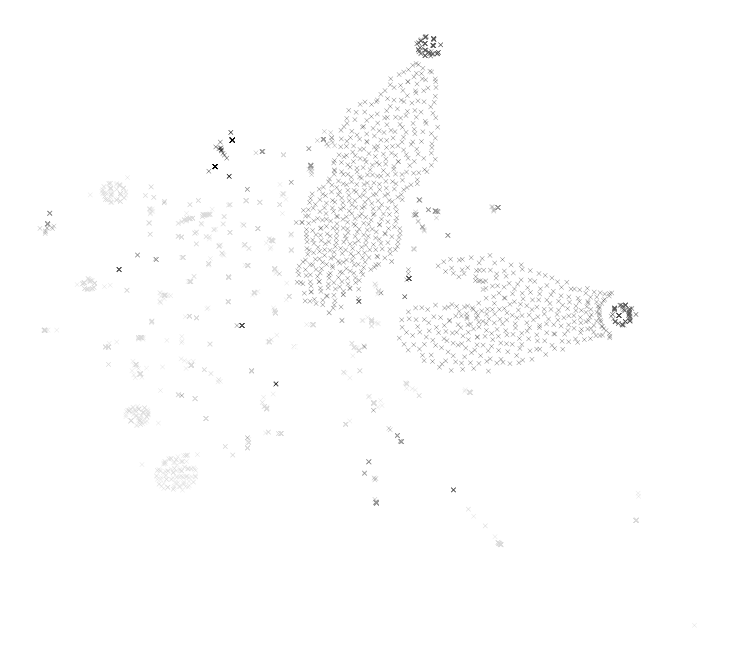

In [128]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(frameon=False)
plt.setp(ax, xticks=(), yticks=())
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.9,
                wspace=0.0, hspace=0.0)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1],
            c=km.labels_, marker="x")

From the plot, we can see there are three strong clusters and several weak clusters. We set up our KMeans classifier with 5, which seems to be about right, so we'll stick with this and add it to our dataframe.

In [129]:
train_dogs['BreedKMeans'] = km_breeds

In [130]:
train_dogs.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,SexuponOutcome,AgeuponOutcome,Breed,Color,NameLength,BreedKMeans
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,0,2,Pit Bull Mix,0,6,3
5,A677334,Elsa,2014-04-25 13:04:00,Transfer,Partner,1,0,Cairn Terrier/Chihuahua Shorthair,1,4,2
12,A684601,Rocket,2016-02-03 11:27:00,Adoption,Foster,0,2,Pit Bull Mix,2,6,3
20,A670658,Anders,2014-01-19 15:03:00,Transfer,Partner,2,0,Queensland Heeler Mix,1,6,1
31,A707341,Murphy,2015-07-15 15:25:00,Transfer,Partner,2,0,Labrador Retriever Mix,1,6,0


In [131]:
train_dogs.columns

Index(['AnimalID', 'Name', 'DateTime', 'OutcomeType', 'OutcomeSubtype',
       'SexuponOutcome', 'AgeuponOutcome', 'Breed', 'Color', 'NameLength',
       'BreedKMeans'],
      dtype='object')

In [132]:
# Work out a test_train_split to see how we do
X = train_dogs.drop(['AnimalID', 'Name', 'DateTime',
                     'OutcomeSubtype', 'Breed'], axis=1)
X.dtypes

OutcomeType        object
SexuponOutcome    float64
AgeuponOutcome      int64
Color               int64
NameLength          int64
BreedKMeans         int32
dtype: object

In [133]:
X.columns

Index(['OutcomeType', 'SexuponOutcome', 'AgeuponOutcome', 'Color',
       'NameLength', 'BreedKMeans'],
      dtype='object')

In [134]:
X.head()

,OutcomeType,SexuponOutcome,AgeuponOutcome,Color,NameLength,BreedKMeans
2,Adoption,0,2,0,6,3
5,Transfer,1,0,1,4,2
12,Adoption,0,2,2,6,3
20,Transfer,2,0,1,6,1
31,Transfer,2,0,1,6,0


In [135]:
X.to_csv(os.path.join(data_dir, "prepared_dogs_df.csv"))

### Frome here, go to the Random Forest Classifier to try out your machine learning model.